## KNN Model Training and Hyperparameter Tuning

In [2]:
# Necessary Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cluster_log_transform import Cluster_Log # This is our handmade function!
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report, roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans

# Display setting set to view whole notebook end to end
pd.set_option('display.max_columns',100)

In [3]:
#Sarah added

from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin

#### Notebook Structure:
- Preliminary Prep
- Initial Baseline Model
- SMOTE
- Fine Tuning

---

### Preliminary Prep

Let's start by loading the data in and doing similar adjustments as done in the EDA.ipynb file:

In [4]:
# Importing data
raw_data = pd.read_csv("online_shoppers_intention.csv")

# Converting certain numerical columns to categorical
num_to_cat_cols = ["OperatingSystems", "Browser", "Region", "TrafficType"]
raw_data[num_to_cat_cols] = raw_data[num_to_cat_cols].astype("category")

# Print original shape, drop duplicates, and print shape to verify
print(raw_data.shape)
clean_data = raw_data.drop_duplicates().reset_index(drop = True)
print(clean_data.shape)

(12330, 18)
(12205, 18)


Now, we will create our design matrix $X$ and response vector $Y$:

In [5]:
# Creating a list of the categorical features to create dummy variables and add them to X
cat_cols = ["Month", "OperatingSystems", "Browser", "Region", 
            "TrafficType", "VisitorType", "Weekend"]
dummy_cols = pd.get_dummies(clean_data[cat_cols])

# Separating clean data into X and Y
X = clean_data.iloc[:,:-1]
Y = clean_data.iloc[:,-1]

# Getting rid of cat cols and replacing them with dummy cols
X = pd.concat([X.drop(columns=cat_cols), dummy_cols.astype(int)], axis=1)

Now, we create the preprocessor that will be used before each time we model. 

**Note: `Cluster_Log` is a function we came up with to transform our dataset how we wanted. It conducts KMeans clustering with k = 5, log(x + 1) transforms some of the columns, and returns X and Y how we want them**

In [6]:
# Cluster_Log requires the names of the numerical columns
num_df = clean_data.select_dtypes(include=["int64", "float64"])
num_cols = num_df.columns

# Creating preprocessor using ColumnTransformer
preprocessor = ColumnTransformer([("add_clusters_and_log", Cluster_Log(k = 5), num_cols)],
                                remainder = "passthrough")

---

### Initial Baseline Model

First model will a vanilla (plain) KNN. We will use a `Pipeline` to stream line the process:

In [7]:
# Creating pipeline
vanilla_pipe = Pipeline(steps = [
    ("preprocessing", preprocessor),
    ("classifier", KNeighborsClassifier())
])

# Train test split ('stratify = Y' and 'shuffle = True' due to class imbalance)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify = Y, test_size=0.2, random_state= 88, shuffle=True)

# Fitting model
vanilla_model = vanilla_pipe.fit(X_train, Y_train)

Next, let's get the predictions and probabilities to get a weighted F1 score, classification report, and AUC score:

Vanilla KNN Weighted F1 Score: 0.88

Vanilla KNN Classification Report
                  precision    recall  f1-score   support

No Purchase Made       0.91      0.96      0.94      2059
   Purchase Made       0.71      0.50      0.58       382

        accuracy                           0.89      2441
       macro avg       0.81      0.73      0.76      2441
    weighted avg       0.88      0.89      0.88      2441


Vanilla KNN AUC Score: 0.84


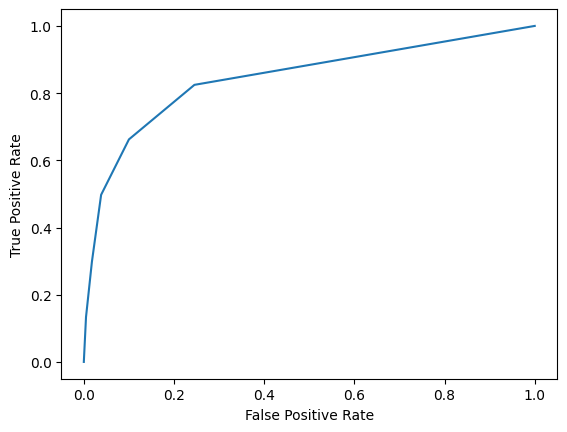

In [8]:
# Predictions and probabilities
y_pred = vanilla_model.predict(X_test)
y_proba = vanilla_model.predict_proba(X_test)[:,1]

# Weighted F1 Score
vanilla_f1 = f1_score(Y_test, y_pred, average = "weighted")
print(f"Vanilla KNN Weighted F1 Score: {vanilla_f1:.2f}")
print()

# Classification Report
class_names = ["No Purchase Made", "Purchase Made"]
print("Vanilla KNN Classification Report")
print(classification_report(Y_test, y_pred, target_names = class_names))
print()

# Simple function to plot the ROC curve
def plot_roc_curve(y_true, y_prob):
    """
    Plots the ROC curve based of the probabilities
    """
    
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(Y_test, y_proba)
print(f'Vanilla KNN AUC Score: {roc_auc_score(Y_test, y_proba):.2f}')

*Initial Model Conclusion*: Model is accurately predicting the non-purchasers but, the model has a bit more trouble with the purchasers. Weighted F1 score is evidence of that discrepancy but the weighted F1 and AUC scores are pretty good. Next, we will fit the model using SMOTE.

### Using SMOTE for Vanilla Model

The motivation for this lies in our poor performance in the minority class prediction. We hope for all models, SMOTE's resampling helps elevate that prediction power. We expect these results to be worse for KNN though since SMOTE relies on synthetically creating points, which messes with structure of the "neighborhood" of the dataset. However, since we are applying it to all models, we'd rather be consistent and apply it to KNN as well. More info on SMOTE can be found on final report. Here is the same implementation as the previous section but with SMOTE:

In [9]:
# Create SMOTE object
smote = SMOTE(random_state = 88, sampling_strategy = 0.6) # Make minority 60% of majority
X_train_res, Y_train_res = smote.fit_resample(X_train, Y_train)

# Fitting model
vanilla_smote_model = vanilla_pipe.fit(X_train_res, Y_train_res)

Vanilla KNN (with SMOTE) Weighted F1 Score: 0.87

Vanilla KNN (with SMOTE) Classification Report
                  precision    recall  f1-score   support

No Purchase Made       0.94      0.89      0.92      2059
   Purchase Made       0.54      0.72      0.62       382

        accuracy                           0.86      2441
       macro avg       0.74      0.80      0.77      2441
    weighted avg       0.88      0.86      0.87      2441


Vanilla KNN (with SMOTE) AUC Score: 0.87


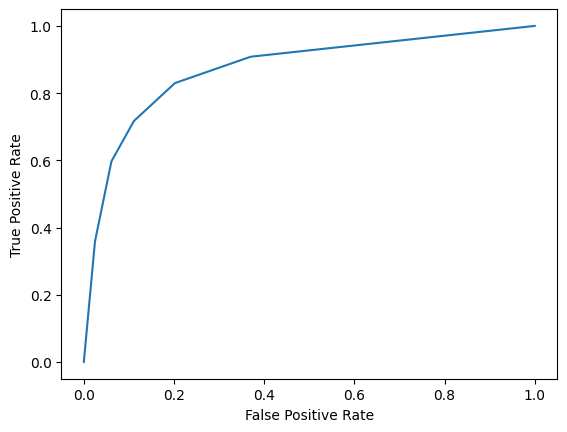

In [10]:
# Predictions and probabilities
y_pred_smote = vanilla_smote_model.predict(X_test)
y_proba_smote = vanilla_smote_model.predict_proba(X_test)[:,1]

# Weighted F1 Score
vanilla_smote_f1 = f1_score(Y_test, y_pred_smote, average = "weighted")
print(f"Vanilla KNN (with SMOTE) Weighted F1 Score: {vanilla_smote_f1:.2f}")
print()

# Classification Report
class_names = ["No Purchase Made", "Purchase Made"]
print("Vanilla KNN (with SMOTE) Classification Report")
print(classification_report(Y_test, y_pred_smote, target_names = class_names))
print()
    
plot_roc_curve(Y_test, y_proba_smote)
print(f'Vanilla KNN (with SMOTE) AUC Score: {roc_auc_score(Y_test, y_proba_smote):.2f}')

---

### Fine-Tuning Model

We will be using `GridSearchCV` to tune the following hyperparameters:

In [11]:
# Couple remarks about the grid:
# - K values are odd to avoid ties
# - P is a hyperparameter that controls KNN using manhattan or euclidean distance
# - 'classifier__" is added to the beginning to make sure pipeline reads it correctly
param_grid_knn = {
    "classifier__n_neighbors": [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25],
    "classifier__weights": ["uniform", "distance"],
    "classifier__p": [1, 2]
}

Now, we'll define our `GridSearchCV`:

In [12]:
# KFold cross val
kf = StratifiedKFold(n_splits= 10, shuffle = True, random_state = 88)

# Creating grid search grid
grid = GridSearchCV(estimator=vanilla_pipe, param_grid=param_grid_knn, 
                    cv=kf, scoring="f1_weighted", n_jobs=-1, verbose=0)

Following this, we will perform grid search to find the optimal parameters for our model:

In [13]:
# Fitting grid onto training data
grid.fit(X_train, Y_train)

,estimator,Pipeline(step...lassifier())])
,param_grid,"{'classifier__n_neighbors': [3, 5, ...], 'classifier__p': [1, 2], 'classifier__weights': ['uniform', 'distance']}"
,scoring,'f1_weighted'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('add_clusters_and_log', ...)]"


Printing the optimal parameters:

In [14]:
print(f"Best Parameters: {grid.best_params_}")
print(f"Best F1 score: {grid.best_score_:.2f}")

Best Parameters: {'classifier__n_neighbors': 13, 'classifier__p': 2, 'classifier__weights': 'distance'}
Best F1 score: 0.88


Now, let's see how the optimal model performs:

Best KNN Weighted F1 Score: 0.88

Best KNN Classification Report
                  precision    recall  f1-score   support

No Purchase Made       0.91      0.97      0.94      2059
   Purchase Made       0.73      0.47      0.58       382

        accuracy                           0.89      2441
       macro avg       0.82      0.72      0.76      2441
    weighted avg       0.88      0.89      0.88      2441


Best KNN AUC Score: 0.87
Best KNN Confusion Matrix
[[1993   66]
 [ 201  181]]


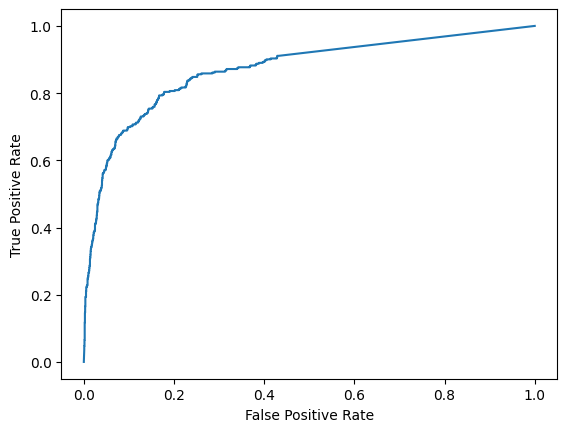

In [15]:
# Saving the best parameters
best_knn_params = grid.best_params_

# Fitting optimal knn model and running it through pipeline
optimal_knn = KNeighborsClassifier(
    n_neighbors= best_knn_params["classifier__n_neighbors"],
    p = best_knn_params["classifier__p"],
    weights = best_knn_params["classifier__weights"]
)
optimal_knn_pipe = Pipeline(steps = [
    ("preprocessing", preprocessor),
    ("classifier", optimal_knn)
])
best_knn_model = optimal_knn_pipe.fit(X_train, Y_train)

# Predictions and probabilities
y_pred_best_knn = best_knn_model.predict(X_test)
y_proba_best_knn = best_knn_model.predict_proba(X_test)[:,1]

# Weighted F1 Score
best_knn_f1 = f1_score(Y_test, y_pred_best_knn, average = "weighted")
print(f"Best KNN Weighted F1 Score: {best_knn_f1:.2f}")
print()

# Classification Report
class_names = ["No Purchase Made", "Purchase Made"]
print("Best KNN Classification Report")
print(classification_report(Y_test, y_pred_best_knn, target_names = class_names))
print()
    
plot_roc_curve(Y_test, y_proba_best_knn)
print(f'Best KNN AUC Score: {roc_auc_score(Y_test, y_proba_best_knn):.2f}')

# Confusion Matrix
print("Best KNN Confusion Matrix")
print(confusion_matrix(Y_test, y_pred_best_knn))

---

# Logistic Regression Base Model Evaluation

Now we will train and hypertune a logistic regression model on the dataset, with the same preprocessing steps. (Note: we are using the solver 'liblinear' for better convergence.)

In [16]:
from sklearn.linear_model import LogisticRegression

logreg_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", LogisticRegression(solver='liblinear'))
])

### Baseline

Weighted F1 score for Vanilla Logistic Regression model: 0.8726918414443263

Classification Report:

                  precision    recall  f1-score   support

No Purchase Made       0.90      0.98      0.94      2059
   Purchase Made       0.81      0.38      0.52       382

        accuracy                           0.89      2441
       macro avg       0.85      0.68      0.73      2441
    weighted avg       0.88      0.89      0.87      2441

ROC AUC score: 0.9010804309518422


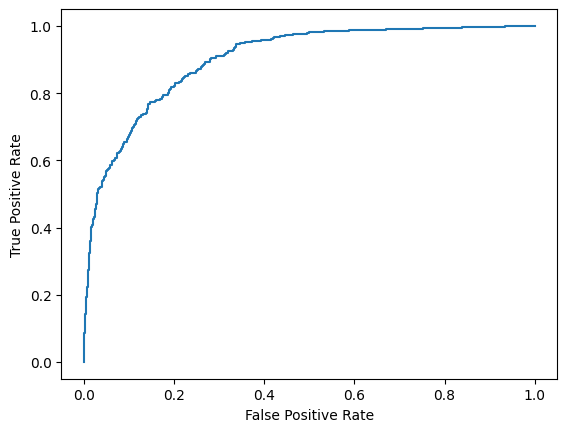

In [17]:
model = logreg_pipeline.fit(X_train, Y_train)

preds = model.predict(X_test)
probs = model.predict_proba(X_test)[:,1]

# F1 Score
print(f"Weighted F1 score for Vanilla Logistic Regression model: {f1_score(Y_test, preds, average='weighted')}")
print("\nClassification Report:\n")

# Classification Report
print(classification_report(Y_test, preds, target_names=class_names))

# ROC Curve
plot_roc_curve(Y_test, probs)
print(f"ROC AUC score: {roc_auc_score(Y_test, probs)}")

The baseline logistic regression model also seems to struggle to identify the visits where purchases were made. Let's see if SMOTE resampling can train a better baseline model.

### Baseline with SMOTE-Resampled training data

Weighted F1 score for SMOTE-trained Vanilla Logistic Regression model: 0.87

Classification Report:

                  precision    recall  f1-score   support

No Purchase Made       0.90      0.98      0.94      2059
   Purchase Made       0.80      0.39      0.52       382

        accuracy                           0.89      2441
       macro avg       0.85      0.69      0.73      2441
    weighted avg       0.88      0.89      0.87      2441

ROC AUC score: 0.9009634626680465


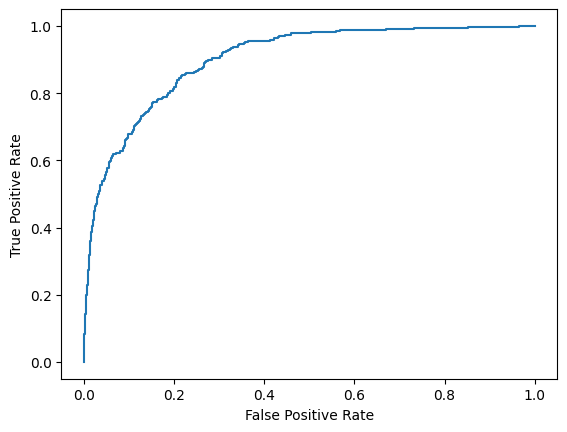

In [18]:
model = logreg_pipeline.fit(X_train_res, Y_train_res)

preds = model.predict(X_test)
probs = model.predict_proba(X_test)[:,1]

# F1 Score
print(f"Weighted F1 score for SMOTE-trained Vanilla Logistic Regression model: {f1_score(Y_test, preds, average='weighted'):.2f}")
print("\nClassification Report:\n")

# Classification Report
print(classification_report(Y_test, preds, target_names=class_names))

# ROC Curve
plot_roc_curve(Y_test, probs)
print(f"ROC AUC score: {roc_auc_score(Y_test, probs)}")

Resampling does not appear to have an appreciable effect on the predictions of the baseline model.

### Hyperparameter Tuning

The only hyperparameter we seek to optimize for the logistic regression model is C, which determines the strength of the L2 penalty on parameter estimates.

In [19]:
# Define parameter grid: 40 C values spaced on a logarithmic scale from 0.0001 to 100
param_grid_logreg = {'classifier__C': np.logspace(-4,2,40)}

# Run grid search
kf = StratifiedKFold(n_splits = 10, shuffle=True, random_state=88)
results = GridSearchCV(logreg_pipeline, 
                       param_grid=param_grid_logreg, 
                       cv=kf,
                       scoring="f1_weighted",
                       n_jobs=-1).fit(X_train, Y_train)

print(f"Best parameters:\n{results.best_params_}\nBest weighted F1 score:\n{results.best_score_}")

Best parameters:
{'classifier__C': np.float64(70.17038286703837)}
Best weighted F1 score:
0.8629642341620943


Now we fit a logistic regression model with the optimal C parameter and measure its performance.

Weighted F1 Score of hypertuned logistic regression model: 0.5169340463458111
Classification Report:

                  precision    recall  f1-score   support

No Purchase Made       0.90      0.98      0.94      2059
   Purchase Made       0.81      0.38      0.52       382

        accuracy                           0.89      2441
       macro avg       0.85      0.68      0.73      2441
    weighted avg       0.88      0.89      0.87      2441

ROC AUC Score: 0.8981040966870004


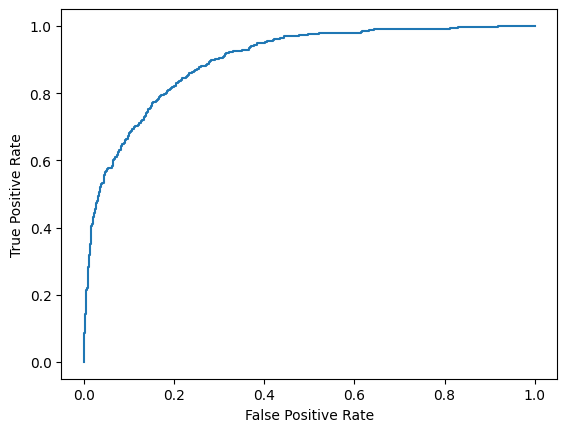

In [20]:
# Define and run new model
tuned_model = logreg_pipeline.set_params(classifier__C = results.best_params_["classifier__C"]).fit(X_train, Y_train)
preds = tuned_model.predict(X_test)
probs = tuned_model.predict_proba(X_test)[:,1]

# Weighted F1 Score
print(f"Weighted F1 Score of hypertuned logistic regression model: {f1_score(Y_test, preds)}")

# Classification report
print("Classification Report:\n")
print(classification_report(Y_test, preds, target_names=class_names))

# ROC Curve and AUC Score
plot_roc_curve(Y_test, probs)
print(f"ROC AUC Score: {roc_auc_score(Y_test, probs)}")

Since the classification metrics are largely unchanged, it appears that hypertuning the C value did not have a substantial effect on the performance of the logistic regression classifier.

# Random Forest Classification

#### Random Forest is a good choice for a model because it's robust to overfitting and sklearn has specific settings to help with class balance

In [21]:
# Creating pipeline
forest_pipe = Pipeline(steps = [
    ("preprocessing",preprocessor),
    ("classifier",RandomForestClassifier())
])

# Fitting model
init_model = forest_pipe.fit(X_train, Y_train)

Initial Random Forest Classifier F1 Score: 0.89

Initial Random Forest Classifier Report
                  precision    recall  f1-score   support

No Purchase Made       0.92      0.97      0.94      2059
   Purchase Made       0.79      0.52      0.63       382

        accuracy                           0.90      2441
       macro avg       0.85      0.75      0.79      2441
    weighted avg       0.90      0.90      0.89      2441


Initial Random Forest Classifier AUC Score: 0.93


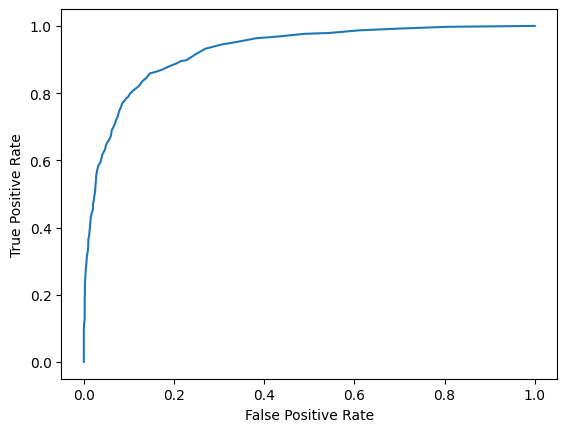

In [22]:
# Predictions and probabilities
y_pred = init_model.predict(X_test)
y_proba = init_model.predict_proba(X_test)[:,1]

# Weighted F1 Score
init_f1 = f1_score(Y_test, y_pred, average = "weighted")
print(f"Initial Random Forest Classifier F1 Score: {init_f1:.2f}")
print()

# Classification Report
class_names = ["No Purchase Made", "Purchase Made"]
print("Initial Random Forest Classifier Report")
print(classification_report(Y_test, y_pred, target_names = class_names))
print()

# Simple function to plot the ROC curve
def plot_roc_curve(y_true, y_prob):
    """
    Plots the ROC curve based of the probabilities
    """
    
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(Y_test, y_proba)
print(f'Initial Random Forest Classifier AUC Score: {roc_auc_score(Y_test, y_proba):.2f}')

While the number of correctly identified purchased / not purchased were decently high, the model struggled significantly with finding the correct number of purchases made. The f1 confirms that the model is strong  when a purchase is not made whereas the model cannot accurately measure if a purchase would be made or not.

This struggle is most likely due to the class imbalance as the Purchases make up only 18% of the data. We can use smote to balance the dataset.

### SMOTE

In [23]:
# Create SMOTE object
smote = SMOTE(random_state = 88, sampling_strategy = 0.6) # Make minority 60% of majority
X_train_res, Y_train_res = smote.fit_resample(X_train, Y_train)

# Fitting model
forest_smote_model = forest_pipe.fit(X_train_res, Y_train_res)

print(f'Y Before:\n{Y_train.value_counts()}\nY After:\n{Y_train_res.value_counts()}')

Y Before:
Revenue
False    8238
True     1526
Name: count, dtype: int64
Y After:
Revenue
False    8238
True     4942
Name: count, dtype: int64


Forest (with SMOTE) Weighted F1 Score: 0.90

Forest (with SMOTE) Classification Report
                  precision    recall  f1-score   support

No Purchase Made       0.93      0.96      0.94      2059
   Purchase Made       0.73      0.61      0.66       382

        accuracy                           0.90      2441
       macro avg       0.83      0.78      0.80      2441
    weighted avg       0.90      0.90      0.90      2441


Forest (with SMOTE) AUC Score: 0.93


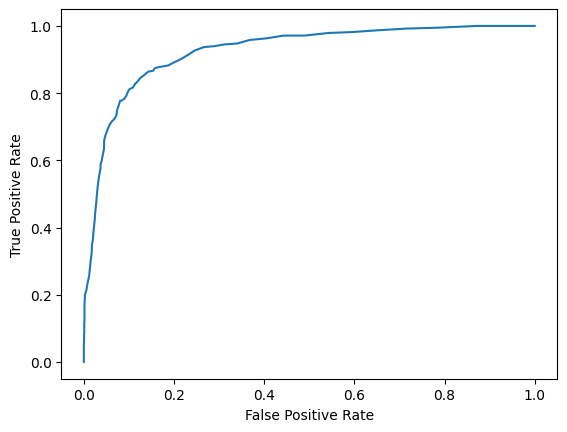

In [24]:
# Predictions and probabilities
y_pred_smote = forest_smote_model.predict(X_test)
y_proba_smote = forest_smote_model.predict_proba(X_test)[:,1]

# Weighted F1 Score
forest_smote_f1 = f1_score(Y_test, y_pred_smote, average = "weighted")
print(f"Forest (with SMOTE) Weighted F1 Score: {forest_smote_f1:.2f}")
print()

# Classification Report
class_names = ["No Purchase Made", "Purchase Made"]
print("Forest (with SMOTE) Classification Report")
print(classification_report(Y_test, y_pred_smote, target_names = class_names))
print()
    
plot_roc_curve(Y_test, y_proba_smote)
print(f'Forest (with SMOTE) AUC Score: {roc_auc_score(Y_test, y_proba_smote):.2f}')

The SMOTE had a minor effect on the `No Purchases Made` report but moderatly improved the `Purchases Made` the ability to predict out of the total possible purchases and struggled more with identifying purchases out of the entire sample.

The change only slightly improve the total F1 score so we can identify if fine tuning will continue to improve it.

### Fine Tuning

Estimators: Checking a wide range of the amount of trees, this will slow it down but will be more thorough.

Max Depth: Checking for how deep the trees should go, checking for max depth with none as well as up to 20 or up to 10. Shorter trees can help reduce overfitting.

Max Features: Number of features in the random subset at each node. None considers all features, sqrt would consider the a random subest of the sqrt of each feature, and log2 considers a random subset of the features.

Class Weight: Automatically adjusts the weights based on the minority purchase class in proportion to its rarity.

Minimum Sample Split: Minimum samples requried for a new branch, smaller amounts allow for fine splits while larger numbers reduce overfitting.

Criterion: Measures the quality of the split. Gini vs entropy

In [25]:
param_grid_forest = {
    "classifier__n_estimators": [50,100,150,200,250,300,350,400,450,500],
    "classifier__max_depth": [None, 20, 10],
    "classifier__max_features": [None,"sqrt"],
    "classifier__class_weight": [None, "balanced","balanced_subsample"],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__criterion": ["gini","entropy"]
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=88)

forest_grid = GridSearchCV(
    estimator=forest_pipe,
    param_grid=param_grid_forest,
    cv=kf,
    scoring="f1_weighted",
    n_jobs=-1,
    verbose=1
)

'''Ensuring we are not using SMOTE variables for this because we are testing if sklearn's 
balancing will improve it.'''

forest_grid.fit(X_train, Y_train)

print("Best params:", forest_grid.best_params_)
print(f"Best CV weighted F1: {forest_grid.best_score_:.3f}")

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
Best params: {'classifier__class_weight': 'balanced', 'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_split': 10, 'classifier__n_estimators': 500}
Best CV weighted F1: 0.898


### The Best Parameters for each one:

Estimators: 500 - The highest amount of trees in the forest, the model could see minor improvements if increased we would greatly increase the training time.

Max Depth: None - no limit on how deep a tree would go. this is balanced by the minimum sample split being 10.

Max Features: Sqrt - Best when considering a random selection of the square root of features. This adds another layer of randomness to decorrelate the trees.

Class Weight: Balanced - Errors on purchases are penalized more heavily than errors on the no purchases.

Minimum Sample Split: 10 - ensuring the branches don't get too small by having at least ten samples before a split.

Criterion: Entropy was a better measure of the spilt quality than gini as entropy is more sentsitive to changes in small probabilities, the default is gini which could be why we were able to use more conservative estimators and depth.

Best CV weighted F1: 0.898
The tuned Random Forest achieved a best cross-validated weighted F1-score of 0.898, indicating strong overall performance across both classes while accounting for the larger proportion of non-purchase sessions.

#### Fitted Model

Tuned RF weighted F1: 0.905

Classification report (tuned RF):

              precision    recall  f1-score   support

 No Purchase       0.94      0.94      0.94      2059
    Purchase       0.70      0.70      0.70       382

    accuracy                           0.91      2441
   macro avg       0.82      0.82      0.82      2441
weighted avg       0.91      0.91      0.91      2441



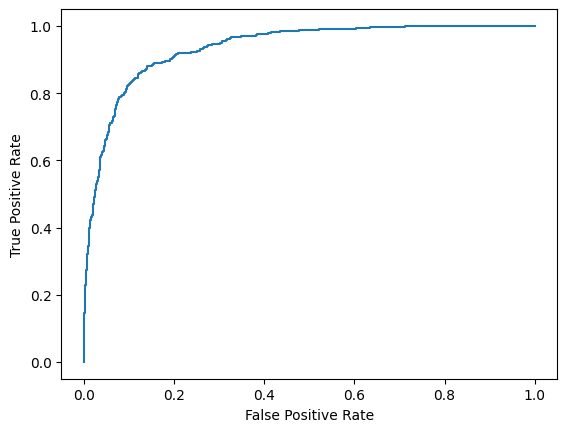

Tuned RF ROC AUC: 0.936


In [26]:
best_rf = forest_grid.best_estimator_

y_pred_best = best_rf.predict(X_test)
y_proba_best = best_rf.predict_proba(X_test)[:, 1]

print(f"Tuned RF weighted F1: {f1_score(Y_test, y_pred_best, average='weighted'):.3f}")
print("\nClassification report (tuned RF):\n")
print(classification_report(Y_test, y_pred_best, target_names=["No Purchase", "Purchase"]))

plot_roc_curve(Y_test, y_proba_best)
plt.show()

print(f"Tuned RF ROC AUC: {roc_auc_score(Y_test, y_proba_best):.3f}")

Even after tuning, the improvement over the SMOTE model is less than 1% the weighted average and the tuned model had a less than 1% improvement for the ROC AUC. While the `No Purchases` f1 score stays the same, the `Purchase` f1 score raises, meaning the tuned model identifies buyers slightly better without hurting performance on non-buyers.

In practice, this Random Forest is most useful for predicting sessions that will not lead to a purchase, so its output could be used to trigger early discounts, proactive chat, or targeted follow-up emails instead of sending the same outreach to every visitor.

### Confusion Matrix
For visualization

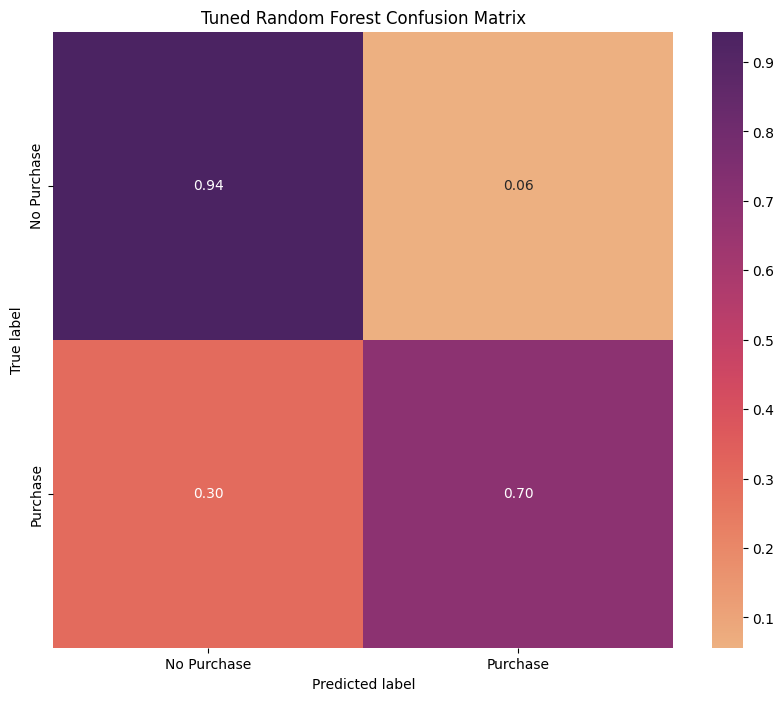

In [30]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(Y_test, y_pred_best)
matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis] #Got from a medium article

labels = ["No Purchase", "Purchase"]

plt.figure(figsize=(10,8))
sns.heatmap(matrix, annot=True, fmt=".2f", cmap="flare",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Tuned Random Forest Confusion Matrix")
plt.show()